# Basic example

## Pair Counting : 1D,2D,3D

In this part we show how to compute 1D ($s$), 2D ($s,\mu$) and 3D ($s,\mu$,$\theta$) correlation function

In [59]:
import numpy as np
import numba as nb
import twopoint_counter as tpc
from matplotlib import pyplot as plt
from numba import njit, prange
import math

In [60]:
Ngal = 300_000
pos_data = np.random.random((int(Ngal),3)) * 2000 -1000
pos_random = np.random.random((int(10*Ngal),3)) * 2000 -1000

s_edges=np.linspace(10,120,20)
bins_s = (np.array(s_edges[1:]) + np.array(s_edges[:-1])) / 2
mu_edges = np.linspace(-1,1,100)
bins_mu = (np.array(mu_edges[1:]) + np.array(mu_edges[:-1])) / 2

#select mode   = 's' (1D),'smu' (2D) or 'smutheta' (3D)
engine = tpc.CorrelationFunction3D(mode='smu',edges=(s_edges,mu_edges),data_positions=pos_data,random_positions=pos_random,data_weights=None,
                                   random_weights=None,RR=None,Nthread=64)

2d : binning along (s,mu)


In [61]:
corr = engine.run()

autocount 7.044100999832153
crosscount 22.179962635040283
autocount 18.439422607421875


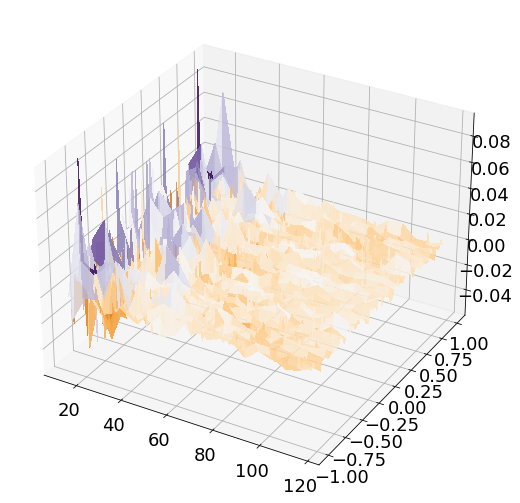

In [62]:
from matplotlib import cm
fig = plt.figure(figsize=(18,9))
ax = plt.axes(projection='3d')

S,MU=np.meshgrid(bins_s,bins_mu)
S,MU = S.T,MU.T

ax.plot_surface(S,MU, corr, cmap=cm.PuOr,
                       linewidth=0, antialiased=False,alpha=0.8)

## Velocity Statistics

In this part we show how to compute velocity auto-correlation and velocity-galaxy cross-correlation function based on [Turner et al. 2022](https://arxiv.org/abs/2207.03707) and [Turner et al. 2021](https://arxiv.org/abs/2101.09026)

In [63]:
# Create Peculiar Velocity catalogs (data and random)
N = int(1000000)
pos = np.random.random((N,3)) * 2000 -1000
v = np.random.randn(N)*400
dat_size = 10000
ran_size = 5*dat_size

#positions 
dat_vpos = pos[np.random.choice(range(pos.shape[0]), size=dat_size, replace=False)]
ran_vpos = pos[np.random.choice(range(pos.shape[0]), size=ran_size, replace=False)]
#velocity
dat_v = np.random.choice(v,dat_size)
ran_v = np.random.choice(v,ran_size)
# velocity error
dat_vsig = np.zeros(dat_size)
ran_vsig = np.zeros(ran_size)
#number density
dat_vn = np.ones(dat_size)*1e-5
ran_vn = np.ones(ran_size)*1e-5
#alpha (eq.(4) Turner 2022) 
dat_alpha = np.ones(dat_size)
ran_alpha = np.ones(ran_size)
#amplitude of the velocity power spectrum
dat_vamp = ran_vamp = 10000

In [64]:
# Create Galaxy catalogs  (data and random)

N = int(100000)
pos = np.random.random((N,3)) * 2000 -1000
dat_size = 10000
ran_size = 5*dat_size

#positions
dat_dpos = pos[np.random.choice(range(pos.shape[0]), size=dat_size, replace=False)]
ran_dpos = pos[np.random.choice(range(pos.shape[0]), size=ran_size, replace=False)]
#number density
dat_dn = np.ones(dat_size)*1e-5
ran_dn = np.ones(ran_size)*1e-5
#amplitude of the galaxy power spectrum
dat_damp = ran_damp = 100000

We can compute auto correlation function using $\psi_1$ and $\psi_2$ statistics : 

In [65]:
#initialize CorrelationFunctionPV class to compute psi1 and psi2
s_edges=np.linspace(0,150,31)
engine = tpc.CorrelationFunctionPV(s_edges,
                                   dat_vpos,dat_vn,dat_v,dat_vsig,dat_alpha,dat_vamp,
                                   ran_vpos,ran_vn,ran_v,ran_vsig,ran_alpha,ran_vamp,
                                   Nthread=10)


In [66]:
psi1 = engine.psi(mode='psi1')

DD count 0.2983856201171875
RR count 1.2786571979522705


In [67]:
psi2 = engine.psi(mode='psi2')

DD count 0.2553832530975342
RR count 1.2686512470245361


We can compute cross correlation function using $\psi_3$ statistic:

In [68]:
#initialize CorrelationFunctionPVD class to compute psi3

bin_s=np.linspace(0,150,31)
bin_mu = np.linspace(-1,1,100)
edges = (bin_s,bin_mu)
engine = tpc.CorrelationFunctionPVD(edges,
                                   dat_vpos,dat_vn,dat_v,dat_vsig,dat_alpha,dat_vamp,
                                   dat_dpos,dat_dn,dat_damp,
                                   ran_vpos,ran_vn,ran_v,ran_vsig,ran_alpha,ran_vamp,
                                   ran_dpos,ran_dn,ran_damp,
                                   Nthread=10)

In [69]:
engine.psi3()

DD count 0.4179058074951172
RD count 1.3829784393310547
DR count 0.8720731735229492
RR count 1.8741610050201416


array([[-9.27119508e+13,  0.00000000e+00,  1.92430497e+02, ...,
        -9.76155146e+02,  2.65790795e+02,  5.40864070e+02],
       [ 1.88026157e+02, -2.68240755e+02, -1.13675967e+03, ...,
        -4.87354349e+02, -6.30884941e+02, -4.02420420e+02],
       [ 1.93503586e+02,  1.96395464e+01, -1.68902692e+02, ...,
        -2.83132125e+02, -3.03997030e+01, -2.58372946e+01],
       ...,
       [ 2.26480347e+01,  7.94630291e+00, -3.70289124e+01, ...,
        -4.63097241e+01, -3.12177568e+01,  8.16090575e+01],
       [-1.19339729e+01, -1.23341018e+01, -2.42642414e+00, ...,
        -2.55021266e+01, -3.15407094e+01, -6.20930185e+01],
       [ 1.92833758e+01,  5.24856157e+00,  3.98955037e+01, ...,
        -1.77706754e+00,  3.64041760e+00, -2.40330166e+01]])